In [1]:
import sys
from pathlib import Path
p_temp = str(Path("~/link/res_publish/").expanduser())
None if p_temp in sys.path else sys.path.append(p_temp)
del p_temp

In [2]:
from func import *
import utils as ut
from utils.general import *
sc = ut.sc.sc
pl = ut.pl

def handle_plot_umap(adata,key):
    cmap = pl.cmap.get(adata.obs[key])
    fig,axs = pl.figure.subplots_get_fig_axs(1,2)
    ut.sc.pl.umap(adata,key,cmap=cmap,ax=axs[0])
    pl.cmap.show(cmap,ax = axs[1],text_x=.02)
    display(fig)
    plt.close('all')

2024-09-02 20:32:38.260648: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[func help]----------------------------------------------------------------
> parameter
    p_root	[name] res_publish
        p_run, p_plot, p_res, p_cache, p_pdf
    p_df_varmap
    map_sp_reverse
    rng
[from func import * ]------------------------------------------------------
| p_root                  | display              | get_res_obs               |
| p_run                   | h5ad_to_mtx          | get_source_obs            |
| p_plot                  | load_adata           | get_matrix_max_prob_median|
| p_res                   | load_normalized_adata| get_matrix_count          |
| p_cache                 | pdf2_merge           | get_path_varmap           |
| p_pdf                   | show_umap            | get_res_stat              |
| p_data_process          | time_tag_detect      | find_path_from_para       |
| map_sp                  | time_tag_get         | func_help                 |
| map_sp_reverse          | time_tag_toggle      |                           |
| map_s

frist 10 adata.X nonzero elements:
 [[ 1 10  1  1  1  4  1  1  2  3]]
[out] /public/workspace/licanchengup/link/res_publish/run/cache/disease/merge_mouse_kideny_healthy_SLE


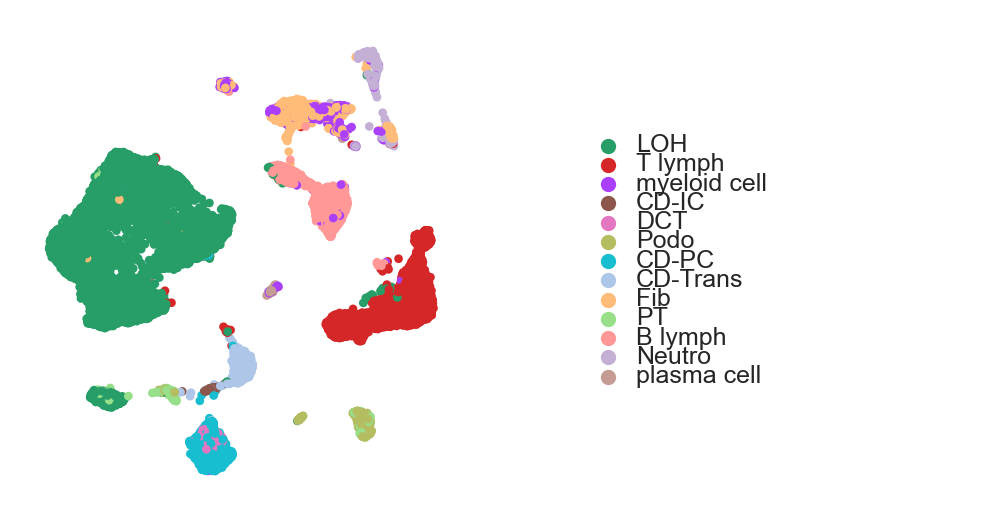

In [3]:
p_merge = Path('./temp_merge_mouse_kideny_healthy_SLE.h5ad').absolute()

if p_merge.exists():
    adata_merge = sc.read_h5ad(p_merge)
    adata_merge = ut.sc.load_obsm_UMAP(adata_merge,'UMAP1,UMAP2'.split(','))
else:
    adata_sle = load_adata(p_cache.joinpath('disease','SLE_mouse_LN_kidney'))
    adata_healthy = load_adata(p_cache.joinpath('healthy/m_kidney'))
    
    print('sle'.ljust(75,'-'))
    ut.sc.show(adata_sle,1)
    display(adata_sle.obs.isna().any())
    
    print('healthy'.ljust(75,'-'))
    ut.sc.show(adata_healthy,1)
    display(adata_healthy.obs.isna().any())
    
    # merge
    
    with Block("merge"):
        adata_merge = sc.concat(
            {'healthy':adata_healthy,'SLE':adata_sle},index_unique=';')
        ut.sc.show(adata_merge,1)
        
        # 整合后的metadata
        # obs_seurat_merge.csv 是 merge_cluster.ipynb 的输出
        df_obs = pd.read_csv('obs_seurat_merge.csv',index_col=0)
        df_obs['seurat_clusters'] = df_obs['seurat_clusters'].astype(str)
        adata_merge = adata_merge[df_obs.index,:]
        adata_merge.obs = adata_merge.obs.loc[:,[]].join(df_obs)
        ut.sc.load_obsm_UMAP(adata_merge,'UMAP1,UMAP2'.split(','))
    
    handle_plot_umap(adata_merge,'pre_cell_type')
    ut.sc.show(adata_merge,1)
    
    adata_merge.write_h5ad(p_merge)
    print('[out] {}\n\t in {}'.format(p_merge.name,p_merge.parent))

    del adata_healthy,adata_sle,adata_merge

with Block('save',context=dict(
        p_out = p_cache.joinpath('disease','merge_mouse_kideny_healthy_SLE'))) as context:
    if context.p_out.exists():
        print('[exists] {}'.format(context.p_out.name))
    else:
        h5ad_to_mtx(adata_merge,context.p_out)

handle_plot_umap(adata_merge,'pre_cell_type')

# adata_imm


In [4]:
display(ut.df.group_agg(adata_merge.obs,['cell_type']))
print(','.join(adata_merge.obs['cell_type'].unique()))

,cell_type,cell_type_count
0,B lymph,2507
1,CD-PC/DCT,1519
2,CD-Trans,873
3,LOH,13027
4,Neutro,453
5,Podo,615
6,T lymph,4189
7,macrophage,1728
8,plasma cell,165
9,proliferating cell,246


LOH,T lymph,Neutro,CD-Trans,CD-PC/DCT,B lymph,macrophage,Podo,proliferating cell,plasma cell


/tmp/ipykernel_145302/1142094715.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_imm.obs['cell_type'] = adata_imm.obs['cell_type'].map(


,_batch,status,cell_type,seurat_clusters,pre_cell_type,UMAP1,UMAP2
AAAGATGGTCCGACGT-1;healthy,lost_7_batches,healthy,T cell,1,T lymph,11.838856,-2.450299
AACACGTGTCGTTGTA-1;healthy,lost_7_batches,healthy,neutrophil,10,myeloid cell,7.933000,8.056559


(9288, 7)

,cell_type,cell_type_count
0,B cell,2507
1,neutrophil,453
2,T cell,4189
3,macrophage,1728
4,plasma cell,165
5,proliferating cell,246


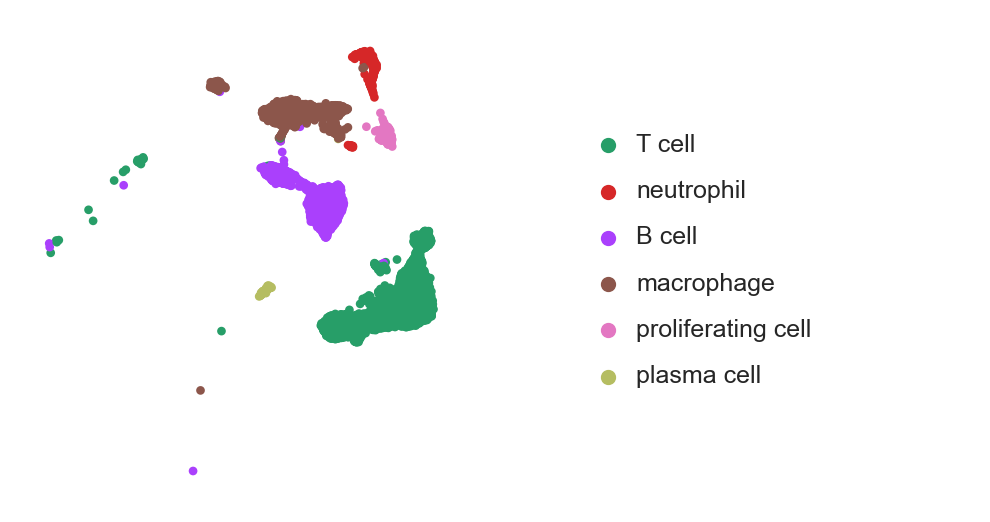

In [5]:
adata_imm = ut.sc.subset_adata(adata_merge,'cell_type','T lymph,Neutro,B lymph,macrophage,proliferating cell,plasma cell'.split(','))
adata_imm.obs['cell_type'] = adata_imm.obs['cell_type'].map(
    lambda k:{
    'T lymph':'T cell',
    'B lymph':'B cell',
    'macrophage':'macrophage',
    'Neutro':'neutrophil',
    'plasma cell':'plasma cell'
}.setdefault(k,k))
display(adata_imm.obs.head(2),adata_imm.obs.shape,
        ut.df.group_agg(adata_imm.obs,['cell_type']))

handle_plot_umap(adata_imm,'cell_type')

In [7]:
with Block('save',context=dict(
        p_out = p_cache.joinpath('disease','merge_mouse_kideny_healthy_SLE_imm'))) as context:
    if context.p_out.exists():
        print('[exists] {}'.format(context.p_out.name))
    else:
        h5ad_to_mtx(adata_imm,context.p_out)

[exists] merge_mouse_kideny_healthy_SLE_imm


# T  and NK

In [8]:
adata_T = ut.sc.subset_adata(adata_imm,'cell_type','T cell')
ut.sc.show(adata_T)

,_batch,status,cell_type,seurat_clusters,pre_cell_type,UMAP1,UMAP2
AAAGATGGTCCGACGT-1;healthy,lost_7_batches,healthy,T cell,1,T lymph,11.838856,-2.450299
AACACGTTCTGAGTGT-1;healthy,lost_7_batches,healthy,T cell,1,T lymph,7.240414,-5.332770


(4189, 7)

In [11]:
# 整合后的metadata
# obs_seurat_merge_T.csv 是 merge_cluster_T.ipynb 的输出
df_obs = pd.read_csv('obs_seurat_merge_T.csv',index_col=0).drop(columns=['orig.ident'])
df_obs['seurat_clusters'] = df_obs['seurat_clusters'].astype(str)
df_obs.head(2)

,_batch,status,seurat_clusters,seurat_clusters_0.25,cell_type,sub_cell_type,UMAP1,UMAP2
cell_name,,,,,,,,
AAAGATGGTCCGACGT-1;healthy,lost_7_batches,healthy,4,4,NK T,NK T,-6.065876,6.291645
AACACGTTCTGAGTGT-1;healthy,lost_7_batches,healthy,14,1,CD4+ T,CD4+ naive,-5.847698,2.842119


True    3976
Name: count, dtype: int64

AnnData object with n_obs × n_vars = 3976 × 16261
    obs: '_batch', 'status', 'seurat_clusters', 'seurat_clusters_0.25', 'cell_type', 'sub_cell_type', 'UMAP1', 'UMAP2'
    var: 'gene_names', 'gene_ids'
    obsm: 'X_umap'

,_batch,status,seurat_clusters,seurat_clusters_0.25,cell_type,sub_cell_type,UMAP1,UMAP2
AAAGATGGTCCGACGT-1;healthy,lost_7_batches,healthy,4,4,NK T,NK T,-6.065876,6.291645
AACACGTTCTGAGTGT-1;healthy,lost_7_batches,healthy,14,1,CD4+ T,CD4+ naive,-5.847698,2.842119


(3976, 8)

cell_type
CD4+ T    1955
CD8+ T    1132
NK T       518
NK         371
Name: count, dtype: int64

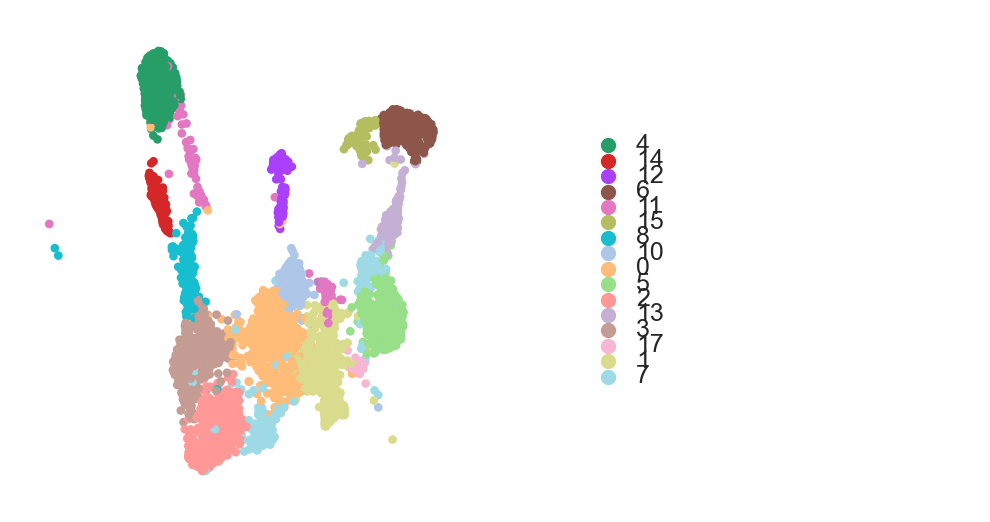

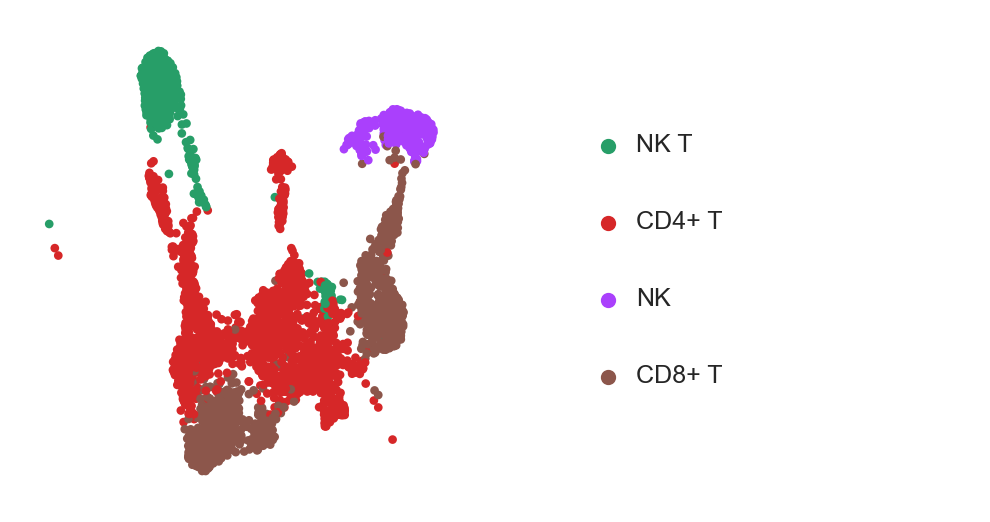

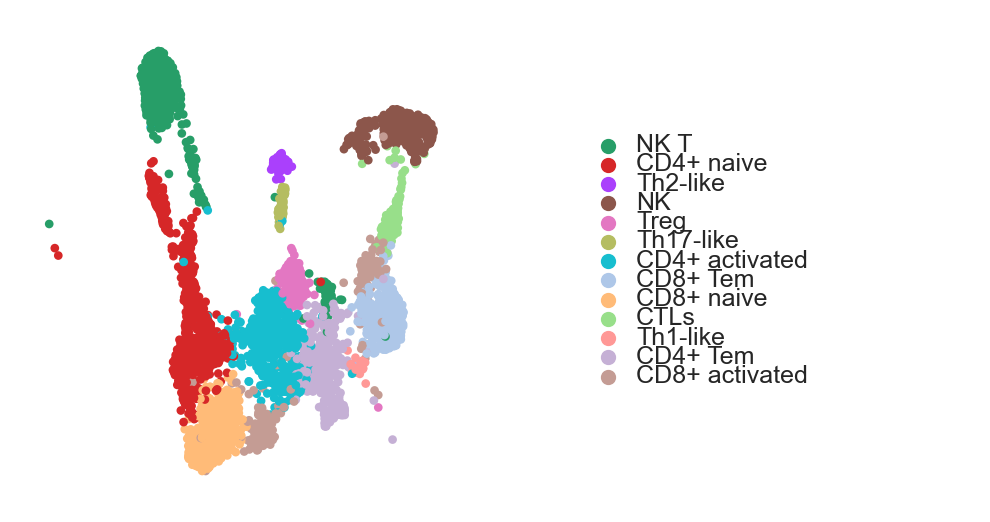

In [13]:
display(pd.Series(adata_T.obs.index.isin(df_obs.index)).value_counts())
adata_T = adata_T[df_obs.index,:]
adata_T.obs = adata_T.obs.loc[:,[]].join(df_obs)
ut.sc.show(adata_T,1)
display(adata_T.obs['cell_type'].value_counts())

adata_T = ut.sc.load_obsm_UMAP(adata_T,'UMAP1,UMAP2'.split(','))
for k in 'seurat_clusters,cell_type,sub_cell_type'.split(','):
    handle_plot_umap(adata_T,k)

/tmp/ipykernel_145302/772360877.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  context.adata.obs['sub_cell_type'] = 'NK'


cell_type
NK    371
Name: count, dtype: int64

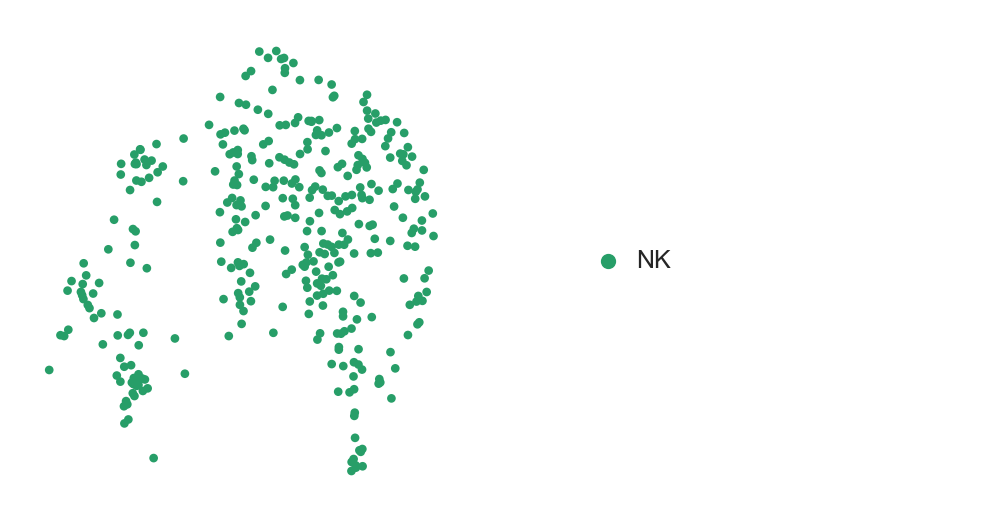

frist 10 adata.X nonzero elements:
 [[1 2 1 1 1 1 1 1 1 1]]
[out] /public/workspace/licanchengup/link/res_publish/run/cache/disease/merge_mouse_kideny_healthy_SLE_imm_NK


In [14]:
with Block("NK",context=dict(adata=ut.sc.subset_adata(adata_T,'cell_type','NK'))) as context :
    context.adata.obs['sub_cell_type'] = 'NK'
    display(context.adata.obs['cell_type'].value_counts())
    handle_plot_umap(context.adata,'cell_type')
    h5ad_to_mtx(context.adata,
                p_cache.joinpath('disease','merge_mouse_kideny_healthy_SLE_imm_NK'))

cell_type
CD4+ T    1955
CD8+ T    1132
Name: count, dtype: int64

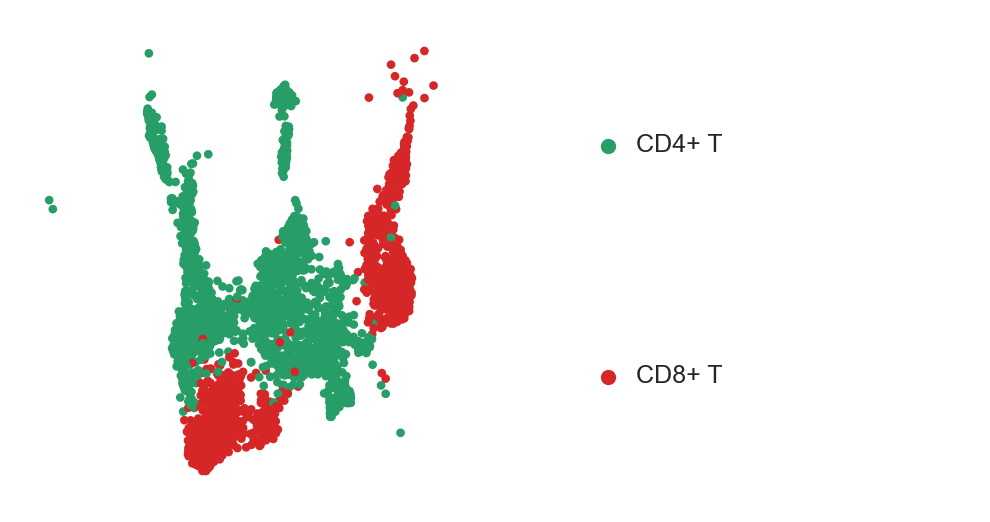

/public/workspace/licanchengup/link/res_publish/func.py:870: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_names"] = adata.var_names.to_numpy()


frist 10 adata.X nonzero elements:
 [[11  1  2  1  2  1  5  1  1  1]]
[out] /public/workspace/licanchengup/link/res_publish/run/cache/disease/merge_mouse_kideny_healthy_SLE_imm_T


In [15]:
with Block("T",context=dict(adata=ut.sc.subset_adata(adata_T,'cell_type','CD4+ T,CD8+ T'.split(',')))) as context :
    display(context.adata.obs['cell_type'].value_counts())
    handle_plot_umap(context.adata,'cell_type')
    h5ad_to_mtx(context.adata,
                p_cache.joinpath('disease','merge_mouse_kideny_healthy_SLE_imm_T'))

In [16]:
del adata_T

# B

In [17]:
adata_imm.obs['cell_type'].value_counts()

cell_type
T cell                4189
B cell                2507
macrophage            1728
neutrophil             453
proliferating cell     246
plasma cell            165
Name: count, dtype: int64

/tmp/ipykernel_145302/3056030413.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  context.adata.obs['sub_cell_type'] = context.adata.obs['cell_type']


,_batch,status,cell_type,seurat_clusters,pre_cell_type,UMAP1,UMAP2,sub_cell_type
AACTCCCGTGTCGCTG-1;healthy,lost_7_batches,healthy,B cell,4,myeloid cell,6.684379,3.053400,B cell
AACTGGTTCGGCTTGG-1;healthy,lost_7_batches,healthy,B cell,4,myeloid cell,7.122852,5.160845,B cell


(2507, 8)

cell_type
B cell    2507
Name: count, dtype: int64

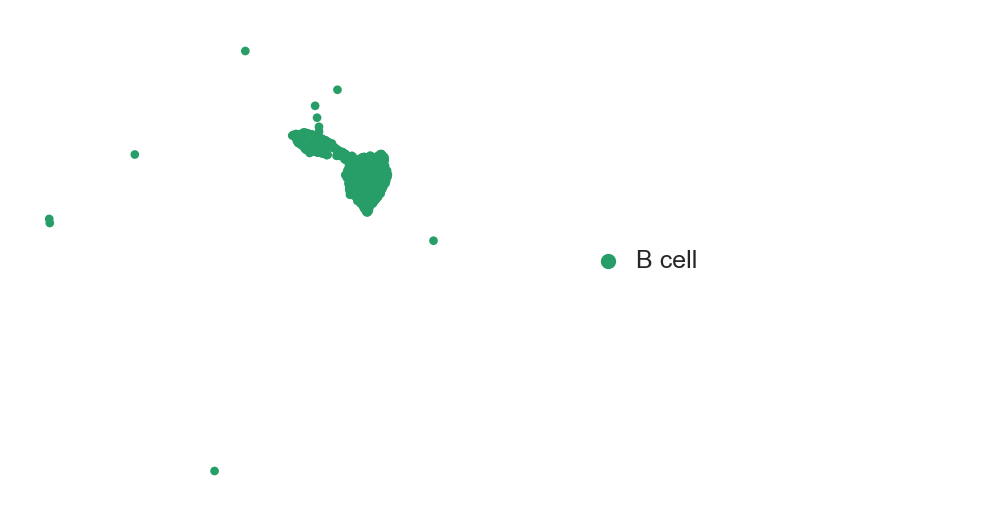

frist 10 adata.X nonzero elements:
 [[1 1 1 3 1 1 2 1 2 9]]
[out] /public/workspace/licanchengup/link/res_publish/run/cache/disease/merge_mouse_kideny_healthy_SLE_imm_B


In [23]:
with Block("macrophage",context=dict(adata=ut.sc.subset_adata(adata_imm,'cell_type','B cell'))) as context :
    context.adata.obs['sub_cell_type'] = context.adata.obs['cell_type']
    ut.sc.show(context.adata)
    display(context.adata.obs['cell_type'].value_counts())
    handle_plot_umap(context.adata,'cell_type')
    h5ad_to_mtx(context.adata,
                p_cache.joinpath('disease','merge_mouse_kideny_healthy_SLE_imm_B'))

# macrophage

/tmp/ipykernel_145302/2514179040.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  context.adata.obs['sub_cell_type'] = context.adata.obs['cell_type']


,_batch,status,cell_type,seurat_clusters,pre_cell_type,UMAP1,UMAP2,sub_cell_type
AACTCCCTCTGAAAGA-1;healthy,lost_7_batches,healthy,macrophage,12,myeloid cell,-0.268396,12.505355,macrophage
AAGGCAGTCCAAACTG-1;healthy,lost_7_batches,healthy,macrophage,5,myeloid cell,4.985463,10.783621,macrophage


(1728, 8)

cell_type
macrophage    1728
Name: count, dtype: int64

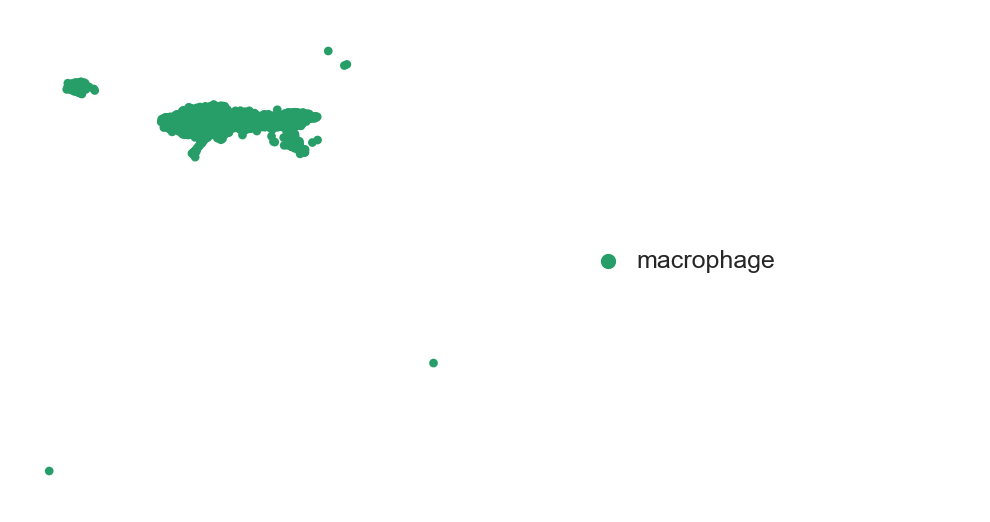

frist 10 adata.X nonzero elements:
 [[3 1 1 4 1 1 6 1 1 1]]
[out] /public/workspace/licanchengup/link/res_publish/run/cache/disease/merge_mouse_kideny_healthy_SLE_imm_mar


In [18]:
with Block("macrophage",context=dict(adata=ut.sc.subset_adata(adata_imm,'cell_type','macrophage'))) as context :
    context.adata.obs['sub_cell_type'] = context.adata.obs['cell_type']
    ut.sc.show(context.adata)
    display(context.adata.obs['cell_type'].value_counts())
    handle_plot_umap(context.adata,'cell_type')
    h5ad_to_mtx(context.adata,
                p_cache.joinpath('disease','merge_mouse_kideny_healthy_SLE_imm_mar'))

In [19]:
print('\n[finish]\n'.center(100,'-'))

---------------------------------------------
[finish]
---------------------------------------------
